In [1]:
import polars as pl
import numpy as np
import os
import json
os.chdir(os.path.expanduser('~/vivarium-ecoli'))
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix

## Load in data from literature sources

In [2]:
#TODO: MIA USE THIS PLOT STYLE: https://seaborn.pydata.org/generated/seaborn.stripplot.html

In [23]:
# load in the "ground truth" data that cyrus collected from Outten & O'Halloran, Science, 2001 (https://pubmed.ncbi.nlm.nih.gov/11397910/): 
GT_data = pd.read_csv("notebooks/mia notebooks/cofactor_ground_truth_data_from_cyrus_for_mia.csv")
GT_data
# TODO: if some of these are below the LOD, should I not include them?
# TODO: does "cell" here just mean its the number for one cell? 
# TODO: why is the log_concentration negative here?


,Condition,Below_LOD,Cell,Element,Distance,ScaleDist,ScaleCounts,Error,Log_concentration,Concentration_(M),Atoms/cell
0,Minimal,0,1,MO,138.225817,354.00,9.08603,1000.000000,-5.485784,3.267501e-06,3983.324414
1,Minimal,0,1,ZN,205.106947,354.00,9.08603,55212.922173,-3.785417,1.639017e-04,199808.236064
2,Minimal,0,1,CU,149.815832,354.00,9.08603,1000.000000,-5.191123,6.439870e-06,7850.676467
3,Minimal,1,1,NI,137.331179,354.00,9.08603,1000.000000,-5.508529,3.100778e-06,3780.077086
4,Minimal,1,1,CO,103.448109,354.00,9.08603,1000.000000,-6.369963,4.266155e-07,520.075813
5,Minimal,0,1,FE,203.321486,354.00,9.08603,24669.603524,-3.830810,1.476353e-04,179978.374255
6,Minimal,0,1,MN,135.088853,354.00,9.08603,1000.000000,-5.565538,2.719333e-06,3315.067378
7,Minimal,0,1,CR,122.171244,354.00,9.08603,1000.000000,-5.893951,1.276582e-06,1556.247155
8,Minimal,0,1,V,113.253635,354.00,9.08603,1000.000000,-6.120670,7.574077e-07,923.335846
9,Rich,0,1,MO,146.248788,353.14,9.30606,1000.000000,-5.272756,5.336351e-06,10797.032626


In [4]:
# load in LB media data from Huynh et al., 2022 fig 1c (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 
LBM_1C = pd.read_excel("notebooks/mia notebooks/Huynh_2022_F1C_LB_media_data.xlsx")
LBM_1C

,metal,atoms/CFU (on log scale),10^ column B,atoms/CFU (non-log scale option),10^ col D
0,Mn,1.924024,83.950673,3.557895,3613.222757
1,Fe,3.409036,2564.696228,5.793684,621847.955106
2,Cu,2.499739,316.038075,4.581053,38111.200706
3,Zn,2.475621,298.965655,4.543158,34926.727413


In [5]:
# load in LB media from Huynh et al., 2022 fig 1d LB (https://journals.asm.org/doi/full/10.1128/spectrum.01006-21): 
LBM_1D = pd.read_excel("notebooks/mia notebooks/Huynh_2022_F1D_LB_media_data.xlsx")
LBM_1D

,metal,atoms/CFU (on log scale),10^ column B,atoms/CFU (non-log scale option),10^ col D
0,V,NAN,NAN,2.708245,510.793360
1,Cr,NAN,NAN,4.232558,17082.763938
2,Co,NAN,NAN,1.983087,96.180423
3,Ni,NAN,NAN,3.389006,2449.099009


In [6]:
# data from Budhraja, et al., 2019 Fig 1 (https://academic.oup.com/metallomics/article/11/5/925/5962190#supplementary-data): 
LBM_F1_2019 = pd.read_excel("notebooks/mia notebooks/Budhraja_2019_F1_data.xlsx")
LBM_F1_2019


,metal,metal ions per cell (ranging from 1000 to 1E+09),Upper error,lower error,metal ions per cell (using 3 to 9 as the axis only),Upper Error,Lower Error,10^ (col E)
0,Mo,1.455079e+04,1.497124e+04,1.414215e+04,4.166667,4.179012,4.154321,1.467799e+04
1,Ni,1.394215e+04,1.475952e+04,1.317006e+04,4.148148,4.172840,4.123457,1.406527e+04
2,Co,3.261385e+03,3.502111e+03,2.994254e+03,3.518519,3.549383,3.481481,3.300035e+03
3,Fe,2.038348e+06,2.157847e+06,1.953087e+06,6.308642,6.333333,6.290123,2.035363e+06


In [7]:
# data from Umemura et al., 2017, table 11.2 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11): 
LBM_T112_2017 = pd.read_excel("notebooks/mia notebooks/Umemura_2017_T112_data.xlsx")
LBM_T112_2017

,Atomic number,Symbol,E. coli MG1655 in LB,E. coli MG1655 in M9,Synechocystis sp. PCC6803 in BG-11,Chlorella kessleri NIES-2160 in Gamborg’s B5,Chloroplast from spinach,Mitochondria from potato tuber,Mitochondria from bovine liver
0,12,Mg,7.500000e+07,110000000.0,120000000.0,1.500000e+09,320000000.0,310000.0,130000.0
1,15,P,4.200000e+08,560000000.0,470000000.0,2.300000e+10,990000000.0,37000000.0,16000000.0
2,16,S,1.700000e+08,150000000.0,400000000.0,1.100000e+10,430000000.0,4400000.0,11000000.0
3,19,K,2.600000e+08,420000000.0,410000000.0,1.800000e+10,760000000.0,15000000.0,9300000.0
4,20,Ca,6.200000e+06,3800000.0,33000000.0,3.600000e+09,14000000.0,80000.0,42000.0
5,21,Sc,4.200000e+02,260.0,NaN,NaN,NaN,NaN,NaN
6,22,Ti,3.900000e+03,NaN,83000.0,9.700000e+06,470000.0,7400.0,1400.0
7,23,V,3.200000e+03,NaN,NaN,NaN,7000.0,220.0,NaN
8,24,Cr,6.000000e+03,4600.0,9700.0,1.500000e+06,15000.0,260.0,58.0
9,25,Mn,1.900000e+05,44000.0,5000000.0,1.000000e+07,3100000.0,3000.0,2500.0


In [8]:
# data from Umemura et al., 2017, table 11.3 (https://link.springer.com/chapter/10.1007/978-4-431-56463-8_11): 
LBM_T113_2017 = pd.read_excel("notebooks/mia notebooks/Umemura_2017_T113_data.xlsx")
LBM_T113_2017

,Atomic number,Symbol,Concentration in LB medium (μg/L),Unnamed: 3,Unnamed: 4,Concentration in M9 medium (μg/L),Unnamed: 6,Unnamed: 7
0,12,Mg,6310.000000,±,240.000000,2.410000e+04,±,250.0000
1,15,P,150000.000000,±,4000.000000,1.730000e+06,±,20000.0000
2,16,S,103000.000000,±,4000.000000,3.010000e+04,±,200.0000
3,19,K,739000.000000,±,41000.000000,8.830000e+05,±,6100.0000
4,20,Ca,8030.000000,±,340.000000,4.050000e+03,±,80.0000
5,21,Sc,0.085000,±,0.014000,NaN,n.d. (<0.02),NaN
6,22,Ti,13.800000,±,5.300000,2.740000e+00,±,0.1700
7,23,V,79.700000,±,4.500000,NaN,n.d. (<0.04),NaN
8,24,Cr,4.580000,±,0.110000,2.110000e+00,±,0.1600
9,25,Mn,18.400000,±,1.000000,2.650000e+00,±,0.0900


Prep data to be merged: 

In [45]:
# minimal media data from GT data: 
GT_mm_data = GT_data[:9]
GT_mm_df = pl.DataFrame(GT_mm_data[["Element","Atoms/cell"]])
GT_mm_df = GT_mm_df.with_columns(pl.col("Atoms/cell").log().alias("GT_mm_log_APC"))

# replace the element names with the column names:
col_names = ["Mo", "Zn", "Cu", "Ni", "Co", "Fe", "Mn", "Cr", "V"]
GT_mm_df = GT_mm_df.with_columns(pl.col("Element").replace(pl.col("Element"), col_names).alias("Element"))
GT_mm_df

Element,Atoms/cell,GT_mm_log_APC
str,f64,f64
"""Mo""",3983.324414,8.289872
"""Zn""",199808.236064,12.205113
"""Cu""",7850.676467,8.968355
"""Ni""",3780.077086,8.2375
"""Co""",520.075813,6.253975
"""Fe""",179978.374255,12.100592
"""Mn""",3315.067378,8.106233
"""Cr""",1556.247155,7.350033
"""V""",923.335846,6.827993


In [20]:
# minimal media from first paper: 
LBM_1C_df = pl.DataFrame(LBM_1C[["metal","atoms/CFU (non-log scale option)"]])
LBM_1C_df = LBM_1C_df.with_columns(pl.col("atoms/CFU (non-log scale option)").alias("LBM_Huynh_log_APC"))

LBM_1D_df = pl.DataFrame(LBM_1D[["metal","atoms/CFU (non-log scale option)"]])
LBM_1D_df = LBM_1D_df.with_columns(pl.col("atoms/CFU (non-log scale option)").alias("LBM_Huynh_log_APC"))

# add the rows from LBM_1D to the bottom of LBM_1C:
LBM_F1_2022_df = LBM_1C_df.vstack(LBM_1D_df)
LBM_F1_2022_df

metal,atoms/CFU (non-log scale option),LBM_Huynh_log_APC
str,f64,f64
"""Mn""",3.557895,3.557895
"""Fe""",5.793684,5.793684
"""Cu""",4.581053,4.581053
"""Zn""",4.543158,4.543158
"""V""",2.708245,2.708245
"""Cr""",4.232558,4.232558
"""Co""",1.983087,1.983087
"""Ni""",3.389006,3.389006


In [75]:
# minimal media from second paper:
LBM_F1_2019_df = pl.DataFrame(LBM_F1_2019[["metal","metal ions per cell (ranging from 1000 to 1E+09)"]])
# add the log of the metal ions per cell to the data frame:
LBM_F1_2019_df = LBM_F1_2019_df.with_columns(pl.col("metal ions per cell (ranging from 1000 to 1E+09)").log10().alias("LBM_Budhraja_log_APC"))
LBM_F1_2019_df

metal,metal ions per cell (ranging from 1000 to 1E+09),LBM_Budhraja_log_APC
str,f64,f64
"""Mo""",14550.790838,4.162887
"""Ni""",13942.154688,4.14433
"""Co""",3261.384943,3.513402
"""Fe""",2.0383e6,6.309278


In [22]:
# minimal media from third paper: LBM_T112_2017
LBM_T112_2017_df = pl.DataFrame(LBM_T112_2017[["Symbol","E. coli\xa0MG1655 in LB"]])
LBM_T112_2017_df = LBM_T112_2017_df.with_columns(pl.col("E. coli\xa0MG1655 in LB").log().alias("LBM_Umemura_T112_log_APC"))
LBM_T112_2017_df

Symbol,E. coli MG1655 in LB,LBM_Umemura_T112_log_APC
str,f64,f64
"""Mg""",7.5e7,18.132999
"""P""",4.2e8,19.855765
"""S""",1.7e8,18.951309
"""K""",2.6e8,19.376192
"""Ca""",6.2e6,15.64006
…,…,…
"""Au""",0.25,-1.386294
"""Tl""",45.0,3.806662
"""Pb""",60.0,4.094345


In [47]:
# Create a data frame of all the data that overlaps with the ground truth data
overlap_element_names = ["Fe", "Mn", "Zn", "Cu", "Co", "Ni", "Mo", "V", "Cr"]

# Select and filter relevant data from each source
H_2022 = LBM_F1_2022_df.select(["metal", "LBM_Huynh_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
B_2019 = LBM_F1_2019_df.select(["metal", "LBM_Budhraja_log_APC"]).filter(pl.col("metal").is_in(overlap_element_names))
U_T112 = LBM_T112_2017_df.select(["Symbol", "LBM_Umemura_T112_log_APC"]).filter(pl.col("Symbol").is_in(overlap_element_names))

# Rename the 'Symbol' column in U_T112 to 'Element' for consistency
H_2022 = H_2022.rename({"metal": "Element"})
B_2019 = B_2019.rename({"metal": "Element"})
U_T112 = U_T112.rename({"Symbol": "Element"})

# Ensure unique column names before joining
H_2022 = H_2022.rename({"LBM_Huynh_log_APC": "Huynh et al., 2022"})
B_2019 = B_2019.rename({"LBM_Budhraja_log_APC": "Budhraja et al., 2019"})
U_T112 = U_T112.rename({"LBM_Umemura_T112_log_APC": "Umamura et al., 2017"})

# Perform outer joins to combine the DataFrames
mm_exp_data = H_2022.join(B_2019, on="Element", how="left")
mm_exp_data = mm_exp_data.join(U_T112, on="Element", how="left")
mm_exp_data

Element,"Huynh et al., 2022","Budhraja et al., 2019","Umamura et al., 2017"
str,f64,f64,f64
"""Mn""",3.557895,null,12.154779
"""Fe""",5.793684,14.52765,15.009433
"""Cu""",4.581053,null,11.0021
"""Zn""",4.543158,null,13.384728
"""V""",2.708245,null,8.070906
"""Cr""",4.232558,null,8.699515
"""Co""",1.983087,8.089907,8.612503
"""Ni""",3.389006,9.542672,9.472705


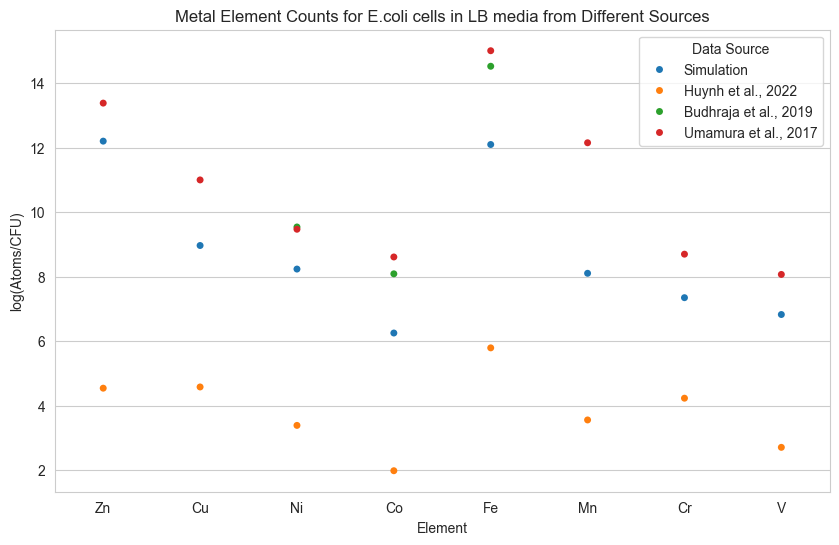

In [74]:
# Combine all data: 
# TODO: ask cyrus if i should be using the minimal media GT data or the Rich media (I read a paper that said the rich media=LB media)
GT_mm = GT_mm_df.select(["Element", "GT_mm_log_APC"])
GT_mm = GT_mm.rename({"GT_mm_log_APC": "Simulation"})
mm_df = GT_mm.join(mm_exp_data, on="Element", how="inner")

# Melt the Polars DataFrame to long format
df_long = mm_df.melt(id_vars=["Element"], variable_name="Data Source", value_name="log(Atoms/CFU)")
# Convert to Pandas DataFrame
df_long_pd = df_long.to_pandas()

# Create the strip plot
plt.figure(figsize=(10, 6))
sns.stripplot(data=df_long_pd, y="log(Atoms/CFU)", x="Element", hue="Data Source", jitter=False)
plt.title("Metal Element Counts for E.coli cells in LB media from Different Sources")
plt.show()


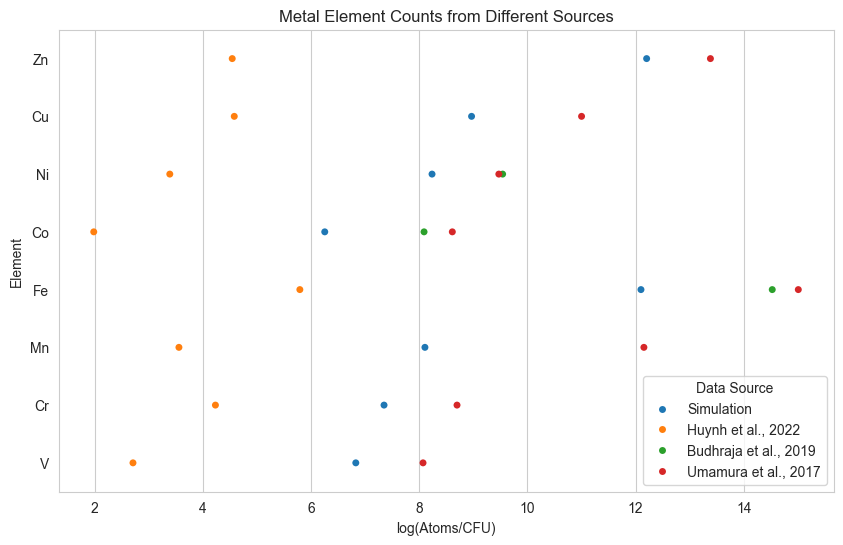

In [73]:
# other orientation: 
plt.figure(figsize=(10, 6))
sns.stripplot(data=df_long_pd, x="log(Atoms/CFU)", y="Element", hue="Data Source", jitter=False)
plt.title("Metal Element Counts from Different Sources")
plt.show()